In [1]:
from google.colab import files
uploaded = files.upload()

Saving text.csv to text.csv



>  * text: A string feature representing the content of the Twitter message.
>  * label: A classification label indicating the primary emotion, with values ranging from 0 to 5.

# 1. Import Libraries


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Import Data


In [ ]:
df = pd.read_csv("/content/text.csv")

In [4]:
df

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [5]:
df = df.drop(columns=['Unnamed: 0'])

In [6]:
df.duplicated().sum()

686

In [7]:
df = df.drop_duplicates()

## Data Preprocess

In [8]:
df1 =df.copy()

In [9]:
df1['text']

0             i just feel really helpless and heavy hearted
1         ive enjoyed being able to slouch about relax a...
2         i gave up my internship with the dmrg and am f...
3                                i dont know i feel so lost
4         i am a kindergarten teacher and i am thoroughl...
                                ...                        
416804    i feel like telling these horny devils to find...
416805    i began to realize that when i was feeling agi...
416806    i feel very curious be why previous early dawn...
416807    i feel that becuase of the tyranical nature of...
416808    i think that after i had spent some time inves...
Name: text, Length: 416123, dtype: object

In [10]:
unique_review = df1['text'].unique()
unique_review

array(['i just feel really helpless and heavy hearted',
       'ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing',
       'i gave up my internship with the dmrg and am feeling distraught',
       ...,
       'i feel very curious be why previous early dawn in the time here don t you seek his trouble',
       'i feel that becuase of the tyranical nature of the government in el salvador and the savage social conditions of the general people that the set of thought to run the shoe shop in miguel marmols testimoney was able to work',
       'i think that after i had spent some time investigating the surroundings and things i started to feel more curious about other people'],
      dtype=object)

In [11]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    # Remove stopwords and stem tokens
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Clean the text data in the 'text' column of DataFrame df
df1['cleaned_text'] = df1['text'].apply(clean_text)

# Print the DataFrame with cleaned text data
print(df1[['text', 'cleaned_text']])

                                                     text  \
0           i just feel really helpless and heavy hearted   
1       ive enjoyed being able to slouch about relax a...   
2       i gave up my internship with the dmrg and am f...   
3                              i dont know i feel so lost   
4       i am a kindergarten teacher and i am thoroughl...   
...                                                   ...   
416804  i feel like telling these horny devils to find...   
416805  i began to realize that when i was feeling agi...   
416806  i feel very curious be why previous early dawn...   
416807  i feel that becuase of the tyranical nature of...   
416808  i think that after i had spent some time inves...   

                                             cleaned_text  
0                        feel realli helpless heavi heart  
1       ive enjoy abl slouch relax unwind frankli need...  
2                    gave internship dmrg feel distraught  
3                          

In [12]:
df1['cleaned_text'] = df1['cleaned_text'].str.replace("http", "").str.replace("href", "").str.replace("img", "").str.replace("irc", "")


In [13]:
unique_review = df1['cleaned_text'].unique()
unique_review

array(['feel realli helpless heavi heart',
       'ive enjoy abl slouch relax unwind frankli need last week around end uni expo late start find feel bit listless never realli good thing',
       'gave internship dmrg feel distraught', ...,
       'feel curiou previou earli dawn time seek troubl',
       'feel becuas tyran natur govern el salvador savag social condit gener peopl set thought run shoe shop miguel marmol testimoney abl work',
       'think spent time investig surround thing start feel curiou peopl'],
      dtype=object)

# Label



In [14]:
df1.label.value_counts()

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

In [15]:
mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

df1['Emotion'] = df1['label'].map(mapping)

# Bigrams



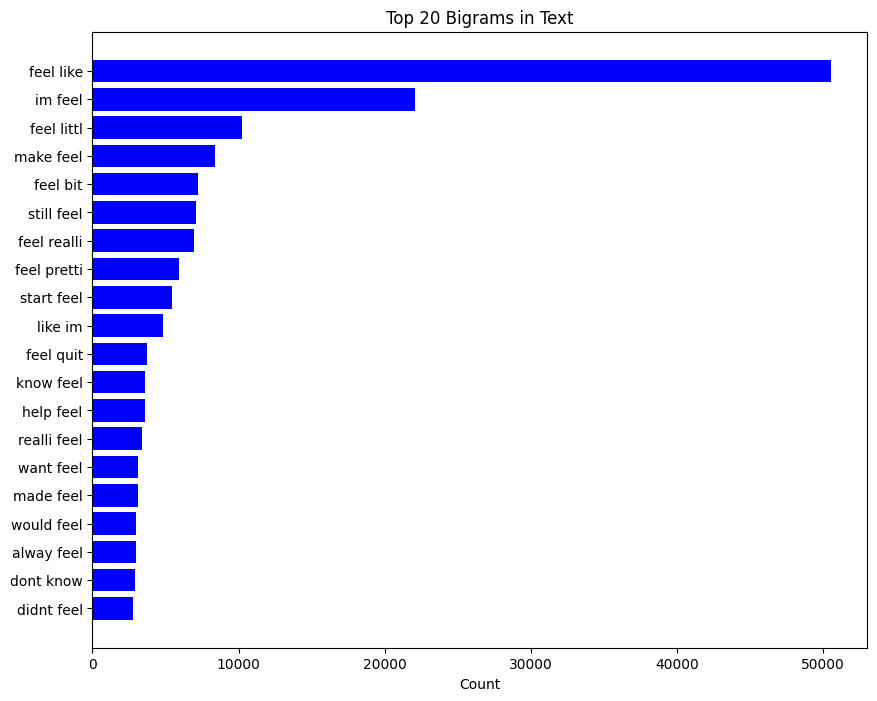

In [16]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_bigrams = get_top_n_bigram(df1['cleaned_text'], 20)

df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_bigrams['bigram'], df_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis()
plt.show()


# WordCloud



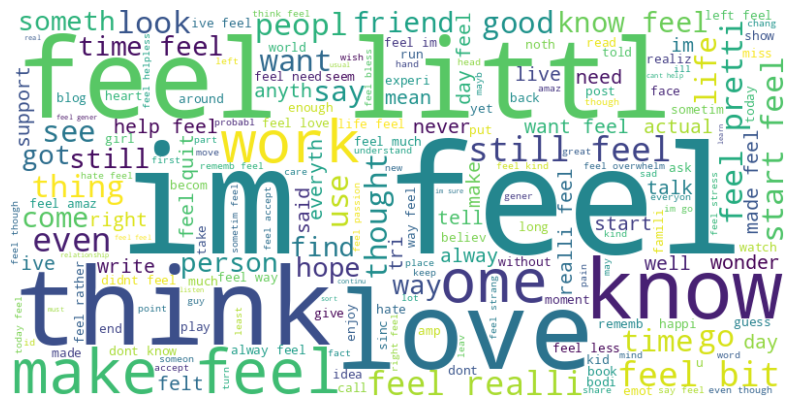

In [ ]:
def make_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_words = ' '.join(df1['cleaned_text'])

make_word_cloud(all_words)

# Modeling


In [18]:
df2 = df1.copy()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df2['cleaned_text'], df2['label'], test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post')

In [22]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=50000, output_dim=16, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=6, activation='softmax'))


In [ ]:
cnn_model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800000    
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           6272      
                                                                 
 dropout (Dropout)           (None, 98, 128)           0         
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=80,
                             validation_data=(X_test_padded, y_test),
                             callbacks=[early_stopping])

Epoch 1/80
10404/10404 [==============================] - 180s 17ms/step - loss: 1.5581 - accuracy: 0.3633 - val_loss: 1.4198 - val_accuracy: 0.5356
Epoch 2/80
10404/10404 [==============================] - 177s 17ms/step - loss: 0.8685 - accuracy: 0.6803 - val_loss: 0.5539 - val_accuracy: 0.8419
Epoch 3/80
10404/10404 [==============================] - 175s 17ms/step - loss: 0.3782 - accuracy: 0.8703 - val_loss: 0.2714 - val_accuracy: 0.9072
Epoch 4/80
10404/10404 [==============================] - 177s 17ms/step - loss: 0.2726 - accuracy: 0.8995 - val_loss: 0.2393 - val_accuracy: 0.9111
Epoch 5/80
10404/10404 [==============================] - 176s 17ms/step - loss: 0.2468 - accuracy: 0.9048 - val_loss: 0.2213 - val_accuracy: 0.9122
Epoch 6/80
10404/10404 [==============================] - 175s 17ms/step - loss: 0.2307 - accuracy: 0.9073 - val_loss: 0.2115 - val_accuracy: 0.9120
Epoch 7/80
10404/10404 [==============================] - 179s 17ms/step - loss: 0.2194 - accuracy: 0.9093

In [26]:
evaluation_result = cnn_model.evaluate(X_test_padded, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])


2601/2601 [==============================] - 9s 3ms/step - loss: 0.1592 - accuracy: 0.9177
Test Loss: 0.1592051386833191
Test Accuracy: 0.9177170395851135


# Confusion Matrix



2601/2601 [==============================] - 7s 3ms/step


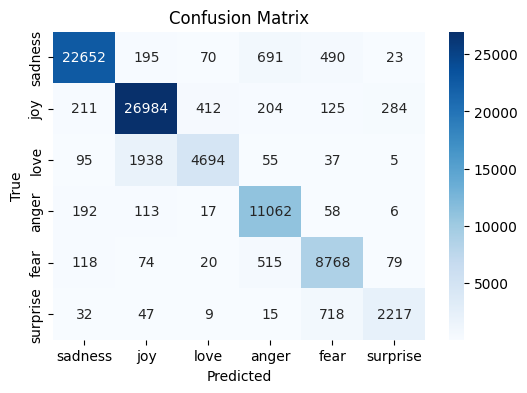

In [27]:
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Classification Report



In [28]:
target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
report = classification_report(y_test, y_pred, target_names=target_names)

print(report)

              precision    recall  f1-score   support

     Sadness       0.97      0.94      0.96     24121
         Joy       0.92      0.96      0.94     28220
        Love       0.90      0.69      0.78      6824
       Anger       0.88      0.97      0.92     11448
        Fear       0.86      0.92      0.89      9574
    Surprise       0.85      0.73      0.78      3038

    accuracy                           0.92     83225
   macro avg       0.90      0.87      0.88     83225
weighted avg       0.92      0.92      0.92     83225



In [29]:
f1_scores = {'Sadness': 0.96, 'Joy': 0.94, 'Love': 0.80, 'Anger': 0.92, 'Fear': 0.88, 'Surprise': 0.81}

threshold = 0.9

chosen_emotion = max(f1_scores, key=lambda emotion: f1_scores[emotion] if f1_scores[emotion] >= threshold else 0)

print(f"The chosen emotion is: {chosen_emotion}")


The chosen emotion is: Sadness


# Training and Validation


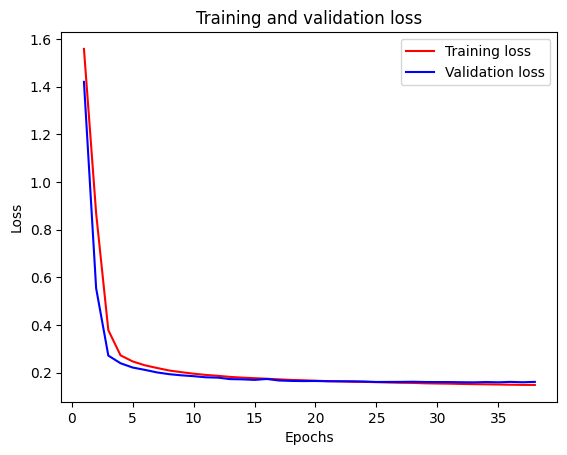

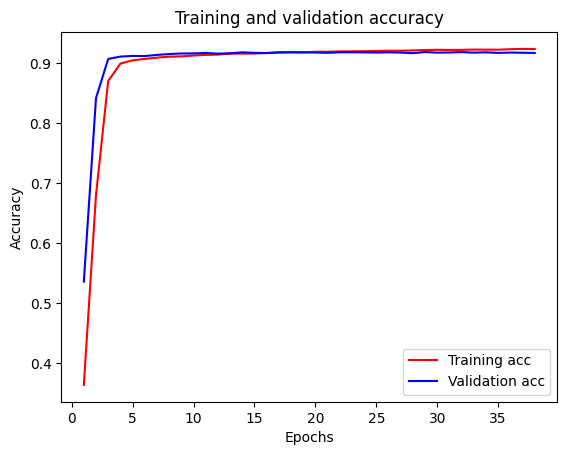

In [30]:
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
train_acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# ROC Curve



2601/2601 [==============================] - 7s 3ms/step


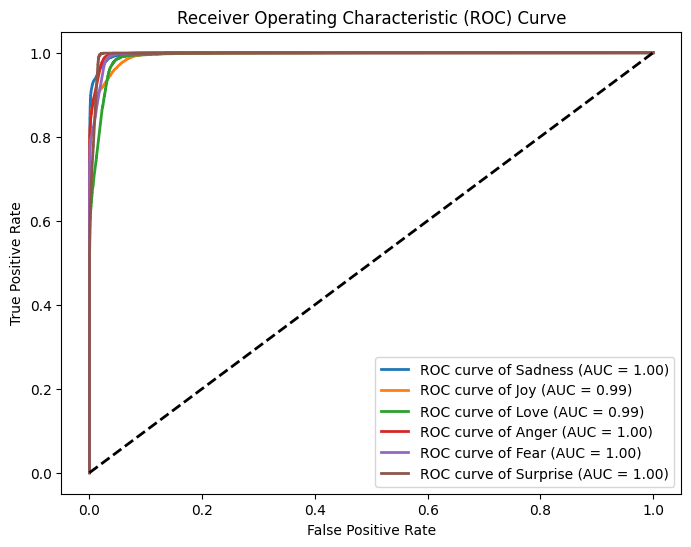

In [31]:
y_score = cnn_model.predict(X_test_padded)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 6
class_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class with distinct colors
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
